# Homework 4

### 1. Now that you have all the tools to train an MLP with high performance on MNIST, try reaching 0-loss (or 100% accuracy) on the training data (with a small epsilon, e.g. 99.99% training performance -- don't worry if you overfit!). The implementation is completely up to you. You just need to keep it an MLP without using fancy layers (e.g., keep the `Linear` layers, don't use `Conv1d` or something like this, don't use attention). You are free to use any LR scheduler or optimizer, any one of batchnorm/groupnorm, regularization methods... If you use something we haven't seen during lectures, please motivate your choice and explain (as briefly as possible) how it works.

In [3]:
import torch

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Deep Learning/scripts/mnist.py')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Deep Learning/scripts/train_utils.py')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Deep Learning/scripts')


import mnist
from train_utils import accuracy, AverageMeter

from torch import nn

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.h1 = nn.Linear(28*28, 16)
        self.h2 = nn.Linear(16, 32)
        self.h3 = nn.Linear(32, 24)
        self.out = nn.Linear(24, 10)
    
    def forward(self, X, activ_hidden=nn.functional.relu):
        out = self.flat(X)
        out = activ_hidden(self.h1(out))
        out = activ_hidden(self.h2(out))
        out = activ_hidden(self.h3(out))
        out = self.out(out)
        return out

  
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance): 
    for X, y in dataloader:
        optimizer.zero_grad() 
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        acc = performance(y_hat, y)
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])


def train_model(model, dataloader1, dataloader2, loss_fn, optimizer, num_epochs, performance=accuracy, lr_scheduler=None, epoch_start_scheduler=1): 
    model.train()

    E = {
        "epoch": [],"training perf": []
    }

    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader1, loss_fn, optimizer, loss_meter, performance_meter, performance)

        if lr_scheduler is not None:
            if epoch >= epoch_start_scheduler:
                lr_scheduler.step()
 
        E["epoch"].append(epoch)
        E["training perf"].append(performance_meter.val)

    return loss_meter.sum, performance_meter.avg, E

In [ ]:
torch.manual_seed(123)

minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

num_epochs = 20

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loss, train_acc, E = train_model(model, trainloader, testloader, loss_fn, optimizer, num_epochs)

The best training performance is 1.0, obtained at epoch no. 9 out of 20.


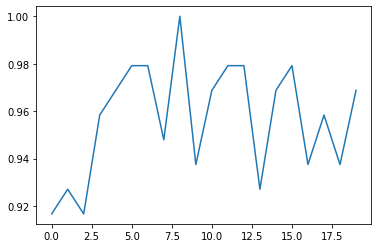

In [6]:
from matplotlib import pyplot as plt

tr_list = list(E["training perf"])
maxval = max(tr_list)
index = tr_list.index(max(tr_list)) + 1 

plt.plot(E["epoch"], E["training perf"] )
print(f"The best training performance is {maxval}, obtained at epoch no. {index} out of {num_epochs}.")

So, with 20 epochs (actually less), Relu layers, cross-entropy loss and ADAM optimizer with a learning rate of 0.01, we're able to have 100% accuracy on training data. 

### 2. Try reaching 0-loss on the training data with permuted labels. Assess the model on the test data (without permuted labels) and comment.

 Tip: To permute the labels, act on the `trainset.targets` with an appropriate torch function. Then, you can pass this "permuted" Dataset to a `DataLoader` like so: `trainloader_permuted = torch.utils.data.DataLoader(trainset_permuted, batch_size=batch_size_train, shuffle=True)`. You can now use this DataLoader inside the training function.

In [7]:
from copy import deepcopy

trainset_permuted = deepcopy(trainset)
permuting_idx = torch.randperm(trainset_permuted.targets.shape[0])
trainset_permuted.targets = trainset_permuted.targets.view(-1)[permuting_idx].view(trainset_permuted.targets.shape)

trainloader_permuted = torch.utils.data.DataLoader(trainset_permuted, batch_size=minibatch_size_train, shuffle=True)

In [8]:
class MLP_perm(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.h1 = nn.Linear(28*28, 1000)
        self.h2 = nn.Linear(1000, 500)
        self.h3 = nn.Linear(500, 250)
        self.out = nn.Linear(250, 10)
    
    def forward(self, X, activ_hidden=nn.functional.relu):
        out = self.flat(X)
        out = activ_hidden(self.h1(out))
        out = activ_hidden(self.h2(out))
        out = activ_hidden(self.h3(out))
        out = self.out(out)
        return out

In [13]:
num_epochs = 100

model = MLP_perm()
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=.9)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=.1)

train_loss, train_acc, E = train_model(model, trainloader_permuted, testloader, loss_fn, optimizer, num_epochs, lr_scheduler=scheduler)

The best training performance is 0.4375, obtained at epoch no. 68 out of 100.


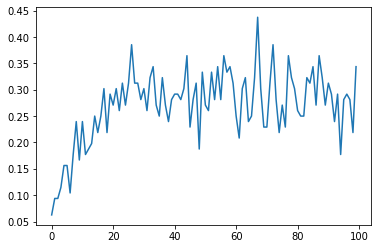

In [14]:
from matplotlib import pyplot as plt

tr_list = list(E["training perf"])
maxval = max(tr_list)
index = tr_list.index(max(tr_list)) + 1 

plt.plot(E["epoch"], E["training perf"] )
print(f"The best training performance is {maxval}, obtained at epoch no. {index} out of {num_epochs}.")

For some reason I am not able to get it past 43.7% accuracy, and arriving there has been a struggle itself. I don't think increasing further the number of epochs would make a significant difference, since it stabilizes around the 30 epoch mark. 